# 1. Read and explore the given dataset. ( Rename column/add headers, plot histograms, find data characteristics)

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style; style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
%matplotlib inline
from math import sqrt


# For Sklearn NearestNeighbor based recommendation
from sklearn.metrics import pairwise_distances, mean_squared_error
from scipy.spatial.distance import correlation, cosine
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import sklearn.metrics as metrics

# Surprise package for making recommendation
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise.model_selection import GridSearchCV, cross_validate, KFold
from surprise import accuracy, Reader, Dataset, dump

# Display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 20
pd.options.display.float_format = "{:.2f}".format

random_state = 2020
np.random.seed(random_state)

import os

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

In [2]:
# Read the data as dataframe and display the first five rows
ratings = pd.read_excel('ratings_Electronics1.xlsx', header = None)
ratings.columns = ['UserID', 'ProductID', 'Rating', 'Timestamp']
ratings.head(3)

,UserID,ProductID,Rating,Timestamp
0,AKM1MP6P0OYPR,132793040,5,1365811200
1,A2CX7LUOHB2NDG,321732944,5,1341100800
2,A2NWSAGRHCP8N5,439886341,1,1367193600


In [3]:
# Retrieve Information of the Dataframe columns
print('Retrieve the dataframe columns'); print('--'*30)
ratings.info()

Retrieve the dataframe columns
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31000 entries, 0 to 30999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   UserID     31000 non-null  object
 1   ProductID  31000 non-null  object
 2   Rating     31000 non-null  int64 
 3   Timestamp  31000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 968.9+ KB


In [4]:
# Check if there any null values in the dataset
print('There are no null values in the dataset'); print('--'*30)
ratings.isnull().sum()

There are no null values in the dataset
------------------------------------------------------------


UserID       0
ProductID    0
Rating       0
Timestamp    0
dtype: int64

In [5]:
# Check if there are any duplicate rows
print('Dataset has no duplicate rows'); print('--'*30)
ratings[ratings.duplicated(keep = 'first')]

Dataset has no duplicate rows
------------------------------------------------------------


,UserID,ProductID,Rating,Timestamp


In [6]:
# Checking the unique values in `Rating` column
print('Checking the uniques in Rating column'); print('--'*30)
sorted(list(ratings['Rating'].unique()))

Checking the uniques in Rating column
------------------------------------------------------------


[1, 2, 3, 4, 5]

In [7]:
ratings.shape

(31000, 4)

Subset of the Original Dataset has 1000 observations and four added columns to avoid Memory issue


Original Dataset has more than 7.8 million reviews and with information regarding User id, Product id, Rating and Timestamp. There are no missing values and duplicates in the dataset. Ratings are on the scale of 1-5


Information on the type of variable

userID: Every user identified with a unique id (Categorical, Nominal).

productID: Every product identified with a unique id (Categorical, Nominal).

Rating: Rating of the corresponding product by the corresponding user (Numerical, Discrete).

Timestamp: Time of the rating (Timestamp).


In [8]:
# Five point summary of numerical attributes and check unique values in 'object' columns
print('Five point summary of the dataframe'); print('--'*30)

ratings.describe(include = 'all')

Five point summary of the dataframe
------------------------------------------------------------


,UserID,ProductID,Rating,Timestamp
count,31000,31000,31000.00,31000.00
unique,29625,2506,nan,nan
top,A243HY69GIAHFI,B00001P4ZH,nan,nan
freq,11,2075,nan,nan
mean,NaN,NaN,4.01,1234194724.34
std,NaN,NaN,1.38,159896347.84
min,NaN,NaN,1.00,912729600.00
25%,NaN,NaN,3.00,1101492000.00
50%,NaN,NaN,5.00,1301616000.00
75%,NaN,NaN,5.00,1367366400.00


Descriptive statistics

UserID: Categorical column with alphanumeric user id. Number of users in the dataset: 4201696.

ProductID: Categorical column with some of the product ids being numerical entries and some being alphanumerics. Numbers of rated products: 476002.

Rating: Users have rated the products on the scale of 1 to 5.

Timestamp: Can be useful if we convert the numerical timestamp to datetime.


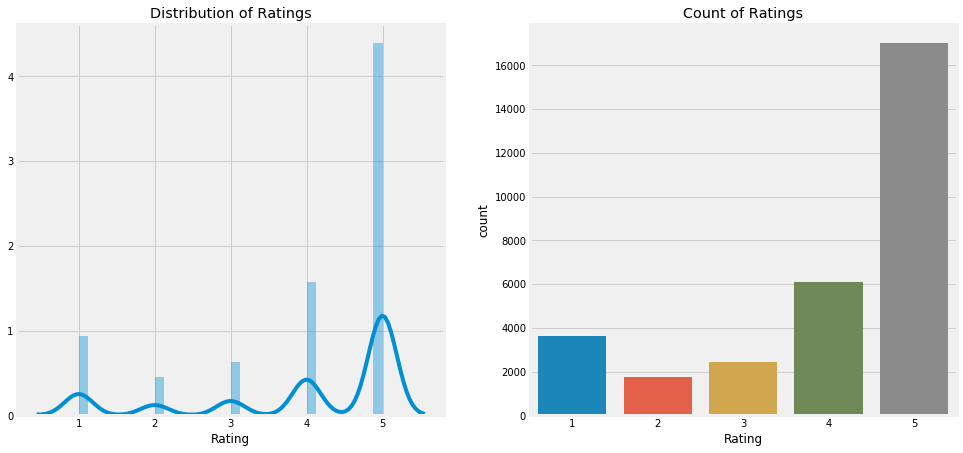

In [9]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(121)
g = sns.distplot(ratings['Rating'], ax = ax).set_title('Distribution of Ratings')
ax = fig.add_subplot(122)
g = sns.countplot(ratings['Rating']).set_title('Count of Ratings')

In [10]:
ratings['Timestamp'] = pd.to_datetime(ratings['Timestamp'], unit = 's')
ratings['Year'] = ratings['Timestamp'].dt.year

Trend of ratings over the years
--------------------------------------------------------------------------------


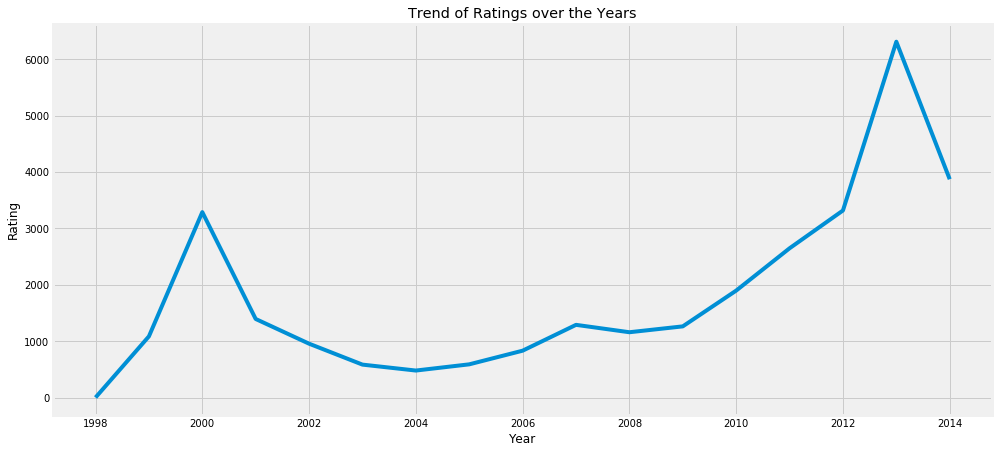

In [11]:
print('Trend of ratings over the years'); print('--'*40)
ratings_over_years = ratings.groupby(by = 'Year', as_index = False)['Rating'].count()

fig = plt.figure(figsize = (15, 7.2))
g = sns.lineplot(x = 'Year', y = 'Rating', data = ratings_over_years).set_title('Trend of Ratings over the Years')

del g, ratings_over_years

# 2. Take a subset of the dataset to make it less sparse/ denser. ( For example,keep the users only who has given 50 or more number of ratings )

Yearwise Counts for Ratings. Trend is similar across rating category.


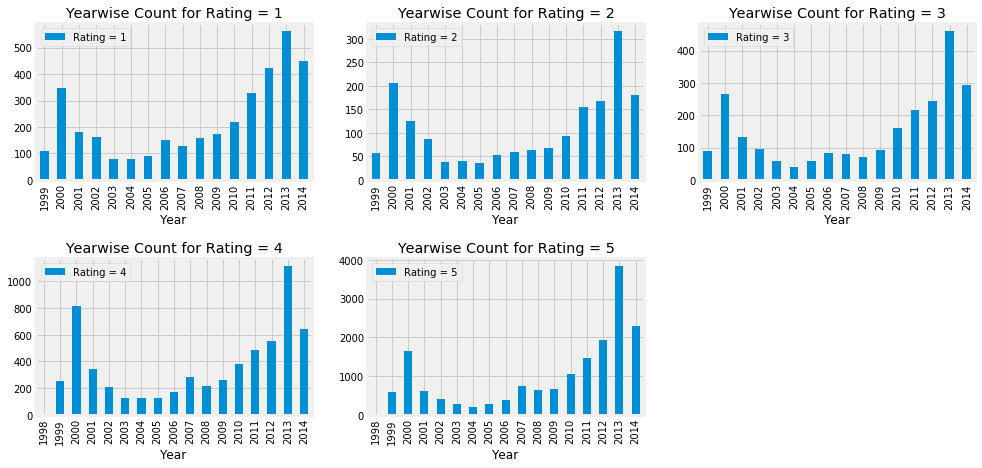

In [12]:
print('Yearwise Counts for Ratings. Trend is similar across rating category.'); 


year_wise_ratings = pd.DataFrame(ratings.groupby(['Rating', 'Year'], as_index = False)['UserID'].count())
year_wise_ratings.rename(columns = {'UserID': 'Counts'}, inplace = True)
ratings_ = sorted(year_wise_ratings['Rating'].unique())

fig, axes = plt.subplots(nrows = 2, ncols = 3, squeeze = False, figsize = (15, 7.2))
plt.subplots_adjust(hspace = 0.5)
axes_list = [item for sublist in axes for item in sublist] 

for rating in ratings_:
    ax = axes_list.pop(0)
    g = year_wise_ratings[year_wise_ratings['Rating'] == rating].plot(kind = 'bar', x ='Year', y = 'Counts', label = f'Rating = {rating}', 
                                                                  ax = ax, legend = True)
    ax.set_title(f'Yearwise Count for Rating = {rating}')

for ax in axes_list:
    ax.remove()

del ax, axes, axes_list, fig, rating, ratings_, year_wise_ratings

In [13]:
print('Adding column with count of rating per user'); print('--'*30)
userid = ratings['UserID'].value_counts()
userid = pd.DataFrame(userid).reset_index()
userid.columns = ['UserID', 'UserIDCounts']

ratings_df = ratings.merge(userid, how = 'left', on = ['UserID'])
display(ratings_df.shape, ratings_df.head())

del userid

Adding column with count of rating per user
------------------------------------------------------------


(31000, 6)

,UserID,ProductID,Rating,Timestamp,Year,UserIDCounts
0,AKM1MP6P0OYPR,132793040,5,2013-04-13,2013,1
1,A2CX7LUOHB2NDG,321732944,5,2012-07-01,2012,1
2,A2NWSAGRHCP8N5,439886341,1,2013-04-29,2013,1
3,A2WNBOD3WNDNKT,439886341,3,2013-07-22,2013,1
4,A1GI0U4ZRJA8WN,439886341,1,2012-04-18,2012,1


In [14]:
# Number of unique user id and product id in the data
print('Number of unique USERS and PRODUCT IDs in the raw ratings dataframe'); print('--'*40)
print('Number of unique USERS in raw ratings dataframe = ', ratings_df['UserID'].nunique())
print('Number of unique PRODUCTS in raw ratings dataframe = ', ratings_df['ProductID'].nunique())

Number of unique USERS and PRODUCT IDs in the raw ratings dataframe
--------------------------------------------------------------------------------
Number of unique USERS in raw ratings dataframe =  29625
Number of unique PRODUCTS in raw ratings dataframe =  2506


Distribution of Ratings  is sparser
--------------------------------------------------------------------------------


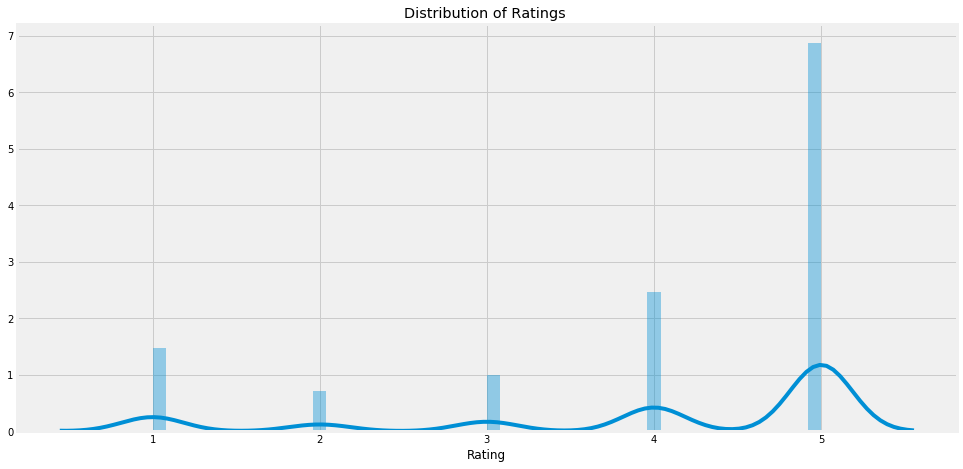

In [15]:
print('Distribution of Ratings  is sparser')
print('--'*40)
fig = plt.figure(figsize = (15, 7.5))
g = sns.distplot(ratings_df['Rating'], bins = 50).set_title('Distribution of Ratings ')

del fig, g

In [16]:
#In this Subset to avoid Memory issue ,Keeping only users those who have given more than 2 number of ratings
print('Taking a subset of dataset to make it less sparse/denser')
print('Keeping users those who have given more than 1 number of ratings'); print('--'*30)

ratings_df = ratings_df[ratings_df['UserIDCounts'] >= 2]
print('Number of rows after filtering: {}'.format(ratings_df.shape[0]))

Taking a subset of dataset to make it less sparse/denser
Keeping users those who have given more than 1 number of ratings
------------------------------------------------------------
Number of rows after filtering: 2334


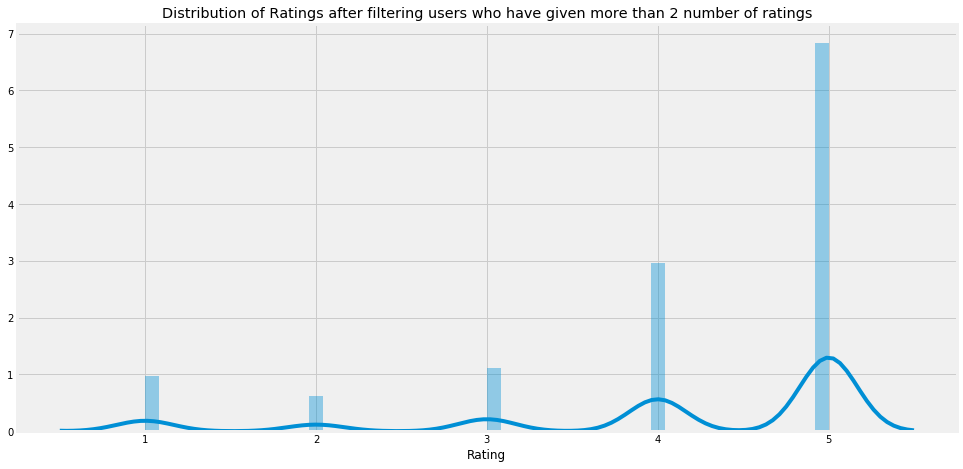

In [17]:
fig = plt.figure(figsize = (15, 7.5))
g = sns.distplot(ratings_df['Rating'], bins = 50).set_title('Distribution of Ratings after filtering users who have given more than 2 number of ratings')

del fig, g

In [18]:
print('Number of product ids after filtering based on ratings given by users: {}'.format(ratings_df['ProductID'].nunique()))

Number of product ids after filtering based on ratings given by users: 782


In [19]:
print('Selecting only UserID, ProductID and \'Rating\' column'); print('--'*30)
ratings = ratings_df[['UserID', 'ProductID', 'Rating']]

Selecting only UserID, ProductID and 'Rating' column
------------------------------------------------------------


In [20]:
# Number of unique user id and product id in the data
print('Number of unique USERS and PRODUCT IDs in the filtered ratings dataframe'); print('--'*30)
print('Number of unique USERS in filtered ratings dataframe = ', ratings['UserID'].nunique())
print('Number of unique PRODUCTS in filtered ratings dataframe = ', ratings['ProductID'].nunique())

Number of unique USERS and PRODUCT IDs in the filtered ratings dataframe
------------------------------------------------------------
Number of unique USERS in filtered ratings dataframe =  959
Number of unique PRODUCTS in filtered ratings dataframe =  782


In [21]:
# Top and bottom 10 users based on # of ratings given
print('Top 10 users based on # of ratings given'); print('--'*30)
most_rated = ratings.groupby('UserID').size().sort_values(ascending = False)[:10]
display(most_rated)

print('\nBottom 10 users based on # of ratings given'); print('--'*40)
least_rated = ratings.groupby('UserID').size().sort_values(ascending = True)[:10]
display(least_rated)

del most_rated, least_rated

Top 10 users based on # of ratings given
------------------------------------------------------------


UserID
A243HY69GIAHFI    11
AJJV9Z17KV6GR     10
A1ISUNUWG0K02V    10
A231WM2Z2JL0U3    10
A1WVMDRJU19AFD     9
A23ZO1BVFFLGHO     9
A1ORUSHRRG0VWN     9
A2B7BUH8834Y6M     8
A6ZPLVAUQ6695      8
A3A15L96IYUO6V     8
dtype: int64


Bottom 10 users based on # of ratings given
--------------------------------------------------------------------------------


UserID
A105R38CAPDBGU    2
A3DZIDWH11X2BF    2
A3E3TUHZHUER7Z    2
A3EMRBL6P6BOZ     2
A3EQQHWJ1EEYEU    2
A3ET8UZUWY0KV3    2
A3F27ADAT2YI8     2
A3F2M27L02YDLM    2
A3F5JV08JUY06C    2
A3FM91FRXZ5MQ3    2
dtype: int64

# 4. Split the data randomly into a train and test dataset. ( For example, split it in 70/30 ratio)

In [22]:
train_data, test_data = train_test_split(ratings, test_size = 0.30, random_state = random_state)
display(train_data.shape, test_data.shape)

(1633, 3)

(701, 3)

In [23]:
print('Number of unique users in training dataframe {}'.format(train_data['UserID'].nunique()))
print('Number of unique users in test dataframe: {}'.format(test_data['UserID'].nunique()))
print('Number of products that aren\'t present in test dataframe: '.format(len(list(set(list(train_data['ProductID'].unique())) - set(list(test_data['ProductID'].unique()))))))

Number of unique users in training dataframe 889
Number of unique users in test dataframe: 534
Number of products that aren't present in test dataframe: 


In [24]:
print('Number of unique products in training dataframe {}'.format(train_data['ProductID'].nunique()))
print('Number of unique products in test dataframe: {}'.format(test_data['ProductID'].nunique()))
print('Number of products that aren\'t present in test dataframe: {}'.format(len(list(set(list(train_data['ProductID'].unique())) - set(list(test_data['ProductID'].unique()))))))

Number of unique products in training dataframe 635
Number of unique products in test dataframe: 396
Number of products that aren't present in test dataframe: 386


# 3. Build Popularity Recommender model.

In [25]:
#Class for Popularity based Recommender System
class popularity_recommender():   
    def __init__(self):
      self.trainSet = None
      self.userId = None
      self.productId = None
      self.popularityRecommendations = None
      self.topN = None
    def create(self, trainSet, userId, productId, topN):
      self.trainSet = trainSet
      self.userId = userId
      self.productId = productId
      self.topN = topN

      byRating = self.trainSet.groupby('ProductID', sort = False, as_index = False)['Rating'].mean().sort_values(by = 'Rating', ascending = False)
      byRating['RatingRank'] = byRating['Rating'].rank(ascending = False, method = 'first')

      byUsers = self.trainSet.groupby('ProductID', sort = False, as_index = False)['Rating'].count().sort_values(by = 'Rating', ascending = False)
      byUsers.columns = ['ProductID', 'RatingCount']
      
      byRatingUsers = pd.merge(byRating, byUsers, on = 'ProductID', how = 'left')
      byRatingUsers = byRatingUsers.sort_values(by = 'RatingRank', ascending = False)

      self.popularity_recommendations = byRating.head(self.topN)
      return byRatingUsers

    def recommend(self, user_id):            
      user_recommendations = self.popularity_recommendations
      
      user_recommendations['UserID'] = user_id
      
      cols = user_recommendations.columns.tolist()
      cols = cols[-1:] + cols[:-1]
      user_recommendations = user_recommendations[cols]
      try:
        print('User has already rated products (from data in training set): {}'.format(self.trainSet.loc[(self.trainSet['UserID'] == user_id), 'ProductID'].nunique()))
        print('Top 5 products from what\'s already being rated: {}'.format(list(self.trainSet[(self.trainSet['UserID'] == user_id)].sort_values(by = 'Rating', ascending = False).head(5)['ProductID'])))
      except:
        print('There\'s no data for the selected user in training set')
      print('\nTop 5 recommendations for the user based on popularity based method: {}'.format(list(user_recommendations['ProductID'])))
      return list(user_recommendations['ProductID'])

# 7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [26]:
# Get top 5 recommendations
print('Popularity recommendation is based on the mean of Ratings received and not Rating counts.')
print('Get top - K ( K = 5) recommendations.')
print('our Objective is to recommend new products to each user based on his/her habits, we will recommend 5 new products.'); print('--'*30)
compare_dict = {}; result = {}
popularity = popularity_recommender()
byRatingUsers = popularity.create(train_data, 'UserID', 'ProductID', 5)

print('\nMake recommendation for the user id selected from the testset = "A11D1KHM7DVOQK"')
user_id = "A11D1KHM7DVOQK"
result[user_id] = popularity.recommend(user_id)

print('\n\nMake recommendation for the user id selected from the testset = "A149RNR5RH19YY"'); print('--'*40)
user_id = "A149RNR5RH19YY"
result[user_id] = popularity.recommend(user_id)

Popularity recommendation is based on the mean of Ratings received and not Rating counts.
Get top - K ( K = 5) recommendations.
our Objective is to recommend new products to each user based on his/her habits, we will recommend 5 new products.
------------------------------------------------------------

Make recommendation for the user id selected from the testset = "A11D1KHM7DVOQK"
User has already rated products (from data in training set): 4
Top 5 products from what's already being rated: ['B00000JCTD', 'B00001ZWRV', 'B000001OMN', 'B00000JBYW']

Top 5 recommendations for the user based on popularity based method: [8862935307, 'B00000J1V7', 'B00001RMCY', 'B00000J1EJ', 'B00001P4PC']


Make recommendation for the user id selected from the testset = "A149RNR5RH19YY"
--------------------------------------------------------------------------------
User has already rated products (from data in training set): 2
Top 5 products from what's already being rated: ['B00000JBAM', 'B00001OPJ1']

To

In [27]:
print('Store the recommendations in a dictionary'); print('--'*30)
compare_dict['PopularityRec'] = result

Store the recommendations in a dictionary
------------------------------------------------------------


# 6. Evaluate the above model. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the testdata.) You can also use a different method to evaluate the models.

In [27]:
from math import sqrt
print('Evaluating Popularity based Recommender')
print('Creating new dataframe with mean rating for each product in test dataframe and using our prediction dataframe i.e. byRatingUsers to calculate RMSE'); print('--'*30)
test_means = test_data.groupby('ProductID', sort = False, as_index = False)['Rating'].mean().sort_values(by = 'Rating', ascending = False)
test_means = test_means.merge(byRatingUsers, on = 'ProductID', how = 'left', suffixes=('_act', '_pred')).drop(['RatingRank', 'RatingCount'], axis = 1).fillna(0)
print('Shape of test mean dataframe: {}'.format(test_means.shape))
print('Shape of predicted (recommender) dataframe: {}'.format(byRatingUsers.shape))

RMSE_pop = sqrt(mean_squared_error(test_means['Rating_act'], test_means['Rating_pred']))
print('--' * 30)
print('RMSE OF THE POPULARITY BASED RECOMMENDER: {}'.format(round(RMSE_pop, 4)))

Evaluating Popularity based Recommender
Creating new dataframe with mean rating for each product in test dataframe and using our prediction dataframe i.e. byRatingUsers to calculate RMSE
------------------------------------------------------------
Shape of test mean dataframe: (396, 3)
Shape of predicted (recommender) dataframe: (635, 4)
------------------------------------------------------------
RMSE OF THE POPULARITY BASED RECOMMENDER: 2.7215


In [28]:
print('Recommendations based on mean of Rating '); print('--'*30)
display(byRatingUsers.sort_values(by = 'RatingRank', ascending = True).head(5)['ProductID'].tolist())

print('\nRecommendations based on count of Rating'); print('--'*30)
display(byRatingUsers.sort_values(by = 'RatingCount', ascending = False).head(5)['ProductID'].tolist())

print('\nRecommendations based on a mix of mean and count of Rating'); print('--'*30)
display(byRatingUsers.sort_values(by = ['Rating', 'RatingCount'], ascending = False).head(5)['ProductID'].tolist())

Recommendations based on mean of Rating 
------------------------------------------------------------


[8862935307, 'B00000J1V7', 'B00001RMCY', 'B00000J1EJ', 'B00001P4PC']


Recommendations based on count of Rating
------------------------------------------------------------


['B00001P4ZH', 'B00001WRSJ', 'B00000J1V5', 'B00000JDF5', 'B00001P4XA']


Recommendations based on a mix of mean and count of Rating
------------------------------------------------------------


[972683275, 'B00000J3NF', 'B00001RMCY', 'B00000J08C', 9983891212]

Plot of average ratings versus number of ratings
--------------------------------------------------------------------------------


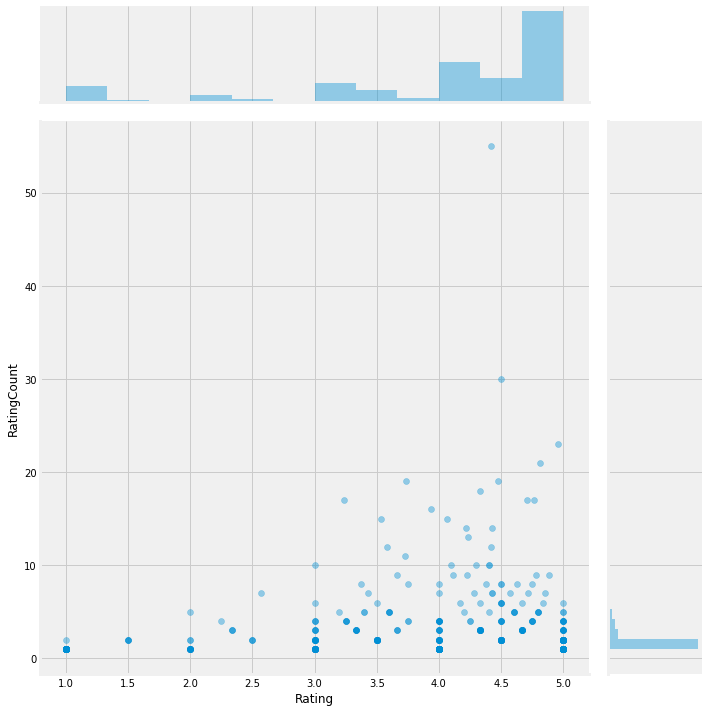

In [29]:
print('Plot of average ratings versus number of ratings'); print('--'*40)
g = sns.jointplot(x = 'Rating', y = 'RatingCount', data = byRatingUsers, alpha = 0.4, height = 10)

del g, byRatingUsers, popularity_recommender, user_id

Popularity Based Recommendation insights:
    
For popularity recommendation system, we recommended products based on mean of Ratings given by users. We saw that the top 5 products which we recommended to users are those where only 1 user from the training set has rated.
Then we also explored other methods for popularity recommendations. Those were based on:
    
Count of Ratings received for the product

Hybrid method for popularity recommendation where in we used both mean and count of rating to decide on the product recommended


For all of the above cases (recommendations based on mean, count, and mean and count), popularity based method lacks personalization i.e. same recommendations for all users. Using Popularity based recommendation system , it would easier to recommend products to a new user w/o having knowledge about who the users are or what their preferences are and recommending them the products that are in-trend.


RMSE of the popularity based recommendation method using mean of rating is 2.7215.


# 5. Build Collaborative Filtering model. ( 20 marks)

Objective is to build a recommendation system to recommend products to customers based on their previous ratings for other products i.e. item-based collaborative filtering.

In [31]:
# Item-based Collaborative Filtering Model
print('Matrix with one row per \'Product\' and one column per \'User\' for Item-based collaborative filtering'); print('--'*30)
ratings_item = ratings.pivot(index = 'UserID', columns = 'ProductID', values = 'Rating').fillna(0)
ratings_item.head()

Matrix with one row per 'Product' and one column per 'User' for Item-based collaborative filtering
------------------------------------------------------------


ProductID,594017343,594017580,594033926,594296420,594450705,594451647,594477670,970407998,972683275,979526191,...,B00002EQBT,B00002EQBU,B00002EQBW,B00002EQBZ,B00002EQC2,B00002EQCD,B00002EQCF,B00002EQCG,B00002EQCS,B00002EQCW
UserID,,,,,,,,,,,,,,,,,,,,,
A105R38CAPDBGU,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A10CMI5RR4XDIV,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A10DIDVYDN2Q5Z,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A10P0BX64HLW7H,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A10SRJNBFF2BGY,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [32]:
# Calculate the density of the rating matrix
print('Calculate the density of the ratings matrix'); print('--'*30)

print('Shape of ratings matrix: ', ratings_item.shape)

given_num_of_ratings = np.count_nonzero(ratings_item)
print('given_num_of_ratings = ', given_num_of_ratings)

possible_num_of_ratings = ratings_item.shape[0] * ratings_item.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Calculate the density of the ratings matrix
------------------------------------------------------------
Shape of ratings matrix:  (959, 782)
given_num_of_ratings =  2334
possible_num_of_ratings =  749938
density: 0.31%


In [40]:
# Matrix Factorization Method-->Singular Value Decomposition(SVD)
U, sigma, Vt = svds(ratings_item, k = 10)
sigma = np.diag(sigma)

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = ratings_item.columns, index = ratings_item.index) 
#predicted ratings
preds_df.head(8)

ProductID,594017343,594017580,594033926,594296420,594450705,594451647,594477670,970407998,972683275,979526191,...,B00002EQBT,B00002EQBU,B00002EQBW,B00002EQBZ,B00002EQC2,B00002EQCD,B00002EQCF,B00002EQCG,B00002EQCS,B00002EQCW
UserID,,,,,,,,,,,,,,,,,,,,,
A105R38CAPDBGU,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,...,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00
A10CMI5RR4XDIV,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.01,...,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00
A10DIDVYDN2Q5Z,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,...,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00
A10P0BX64HLW7H,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.01,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A10SRJNBFF2BGY,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.02,-0.00,...,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00
A10T43ROKRQALT,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,...,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00
A11617B1NW474D,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00
A11D1KHM7DVOQK,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [34]:
# Product Recommendation with highest predicted ratings
print('Creating a function to recommend products with highest predicted ratings'); print('--'*30)
def recommend_items(user_id, ratings_item, preds_df, num_recommendations = 5):
    try:
        print('User has already rated products (from data in training set): {}'.format(train_data.loc[(train_data['UserID'] == user_id), 'ProductID'].nunique()))
        print('Top 5 products from what\'s already being rated: {}'.format(list(train_data[(train_data['UserID'] == user_id)].sort_values(by = 'Rating', ascending = False).head(5)['ProductID'])))
    except:
      print('There\'s no data for the selected user in training set')
    sorted_user_ratings = ratings_item.loc[user_id].sort_values(ascending = False)
    
    sorted_user_predictions = preds_df.loc[user_id].sort_values(ascending = False)
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis = 1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending = False)
    print('\nTop 5 recommendations for the user based on item-based collaborative filtering method')
    display(temp.head(num_recommendations))
    return temp.head(num_recommendations).index.tolist()

Creating a function to recommend products with highest predicted ratings
------------------------------------------------------------


# 7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [41]:
print('Get top - K ( K = 5) recommendations.')
print('Our Objective is to recommend new products to each user based on his/her habits, we will recommend 5 new products.'); print('--'*30)
result = {}

user_id = "A10DIDVYDN2Q5Z"
print(f'\nMake recommendation for the user id selected from the testset = "{user_id}"')
result[user_id] = recommend_items(user_id, ratings_item, preds_df)

user_id = "A11617B1NW474D"
print(f'\n\nMake recommendation for the user id selected from the testset = "{user_id}"')
result[user_id] = recommend_items(user_id, ratings_item, preds_df)

Get top - K ( K = 5) recommendations.
Our Objective is to recommend new products to each user based on his/her habits, we will recommend 5 new products.
------------------------------------------------------------

Make recommendation for the user id selected from the testset = "A10DIDVYDN2Q5Z"
User has already rated products (from data in training set): 3
Top 5 products from what's already being rated: ['B00001U0SI', 'B00001P4ZR', 'B00002EIVE']

Top 5 recommendations for the user based on item-based collaborative filtering method


,user_ratings,user_predictions
Recommended Items,,
B00000JSGF,0.00,0.44
B00001P4ZH,0.00,0.21
B000023VUL,0.00,0.17
B00000J061,0.00,0.15
B00001W0DI,0.00,0.13




Make recommendation for the user id selected from the testset = "A11617B1NW474D"
User has already rated products (from data in training set): 2
Top 5 products from what's already being rated: ['B00000JHWX', 'B00000JFMH']

Top 5 recommendations for the user based on item-based collaborative filtering method


,user_ratings,user_predictions
Recommended Items,,
B00000JSGF,0.00,0.03
B00001P4XH,0.00,0.03
B000023VUL,0.00,0.01
B00001W0DI,0.00,0.01
B00000J061,0.00,0.01


In [42]:
compare_dict['SVD Item-based Collaborative Filtering'] = result

# 6. Evaluate the above model. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the testdata.) You can also use a different method to evaluate the models. 

In [43]:
print('Evaluating SVD for Item-based Collaborative Filtering using RMSE'); print('--'*30)
rmse_df = pd.concat([ratings_item.mean(), preds_df.mean()], axis = 1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
RMSE = round((((rmse_df['Avg_actual_ratings'] - rmse_df['Avg_predicted_ratings']) ** 2).mean() ** 0.5), 4)
print('RMSE OF ITEM BASED COLLABORATIVE FILTERING USING MATRIX FACTORIZATION METHOD (SVD): {}'.format(RMSE))

Evaluating SVD for Item-based Collaborative Filtering using RMSE
------------------------------------------------------------
RMSE OF ITEM BASED COLLABORATIVE FILTERING USING MATRIX FACTORIZATION METHOD (SVD): 0.0103


In [ ]:
Item Based Collaborative Filtering using MATRIX FACTORIZATION METHOD (SVD)

Evaluated SVD for item-based collaborative filtering and RMSE of SVD model 0.0103.

In [45]:
del (RMSE, U, sigma, Vt, all_user_predicted_ratings, given_num_of_ratings, possible_num_of_ratings, result, rmse_df, 
     density, preds_df, recommend_items, user_id)

# Product Similarity based on Sklearn Nearest Neighbor (KNN Method)

In [46]:
# For Sklearn NearestNeighbor based recommendation
from sklearn.metrics import pairwise_distances, mean_squared_error
from scipy.spatial.distance import correlation, cosine
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import sklearn.metrics as metrics

In [47]:
print('Product similarity based on Sklearn Nearest Neighbor'); print('--'*30)
k = 5
df_knn = ratings.pivot(index = 'ProductID', columns = 'UserID', values = 'Rating').fillna(0)
df_knn_matrix = csr_matrix(df_knn.values)

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors = k)
model_knn.fit(df_knn_matrix)

query_item = np.random.choice(df_knn.shape[0])
query_user = np.random.choice(df_knn.shape[1])
distances, indices = model_knn.kneighbors(df_knn.iloc[query_item, :].values.reshape(1, -1), n_neighbors = k+1)

for i in range(0, len(distances.flatten())):
  if i == 0:
    print('Recommendations for {0}:\n'.format(df_knn.index[query_item]))
  else:
    print('{0}: {1}, with distance of {2}:'.format(i, df_knn.index[indices.flatten()[i]], distances.flatten()[i]))

Product similarity based on Sklearn Nearest Neighbor
------------------------------------------------------------
Recommendations for B00000JDH5:

1: B00001X5C6, with distance of 0.600956557766189:
2: B00000JBHA, with distance of 0.600956557766189:
3: B00000J57A, with distance of 0.6807652462129512:
4: B00000JBB8, with distance of 0.6807652462129512:
5: B00001P4PL, with distance of 0.6883994223468353:


# Item based Collaborative Filtering Model using KNN Method

In [48]:
print('Framing the trainset and testset ready for Product Recommendation system'); print('--'*40)
reader = Reader(rating_scale = (0, 5))
data = Dataset.load_from_df(ratings[['UserID', 'ProductID', 'Rating']], reader)
trainset = Dataset.load_from_df(train_data[['UserID', 'ProductID', 'Rating']], reader); 
testset = Dataset.load_from_df(test_data[['UserID', 'ProductID', 'Rating']], reader);

Framing the trainset and testset ready for Product Recommendation system
--------------------------------------------------------------------------------


In [49]:
print('ITEM BASED COLLABORATIVE FILTERING USING KNN Method')
print('Grid Search across parameter grid to find best parameters using KNNBasic algorithm'); print('--'*40)
param_grid_KNNBasic = {'k': [3, 5, 10], 'sim_options': {'name': ['pearson_baseline', 'cosine'], 'user_based': [False]}, 'verbose': [False]}

gs_KNNBasic = GridSearchCV(KNNBasic, param_grid_KNNBasic, measures = ['rmse', 'mae'], cv = 5)
gs_KNNBasic.fit(trainset)
print(gs_KNNBasic.best_score['rmse'])
print(gs_KNNBasic.best_params['rmse'])

ITEM BASED COLLABORATIVE FILTERING USING KNN Method
Grid Search across parameter grid to find best parameters using KNNBasic algorithm
--------------------------------------------------------------------------------
1.2314574494242996
{'k': 3, 'sim_options': {'name': 'cosine', 'user_based': False}, 'verbose': False}


In [50]:
print('Grid Search across parameter grid to find best parameters using KNNWithMeans algorithm'); print('--'*40)
param_grid_KNNWithMeans = {'k': [3, 5, 10], 'sim_options': {'name': ['pearson_baseline', 'cosine'], 'user_based': [False]}, 'verbose': [False]}

gs_KNNWithMeans = GridSearchCV(KNNWithMeans, param_grid_KNNWithMeans, measures = ['rmse', 'mae'], cv = 5)
gs_KNNWithMeans.fit(trainset)
print(gs_KNNWithMeans.best_score['rmse'])
print(gs_KNNWithMeans.best_params['rmse'])

Grid Search across parameter grid to find best parameters using KNNWithMeans algorithm
--------------------------------------------------------------------------------
1.2736949514114548
{'k': 3, 'sim_options': {'name': 'cosine', 'user_based': False}, 'verbose': False}


In [51]:
print('Grid Search across parameter grid to find best parameters using KNNWithZScore algorithm'); print('--'*40)
param_grid_KNNWithZScore = {'k': [3, 5, 10], 'sim_options': {'name': ['pearson_baseline', 'cosine'], 'user_based': [False]}, 'verbose': [False]}

gs_KNNWithZScore = GridSearchCV(KNNWithZScore, param_grid_KNNWithZScore, measures = ['rmse', 'mae'], cv = 5)
gs_KNNWithZScore.fit(trainset)
print(gs_KNNWithZScore.best_score['rmse'])
print(gs_KNNWithZScore.best_params['rmse'])

Grid Search across parameter grid to find best parameters using KNNWithZScore algorithm
--------------------------------------------------------------------------------
1.31579098562645
{'k': 3, 'sim_options': {'name': 'cosine', 'user_based': False}, 'verbose': False}


In [52]:
print('Grid Search across parameter grid to find best parameters using KNNBaseline algorithm'); print('--'*40)
param_grid_KNNBaseline = {'bsl_options': {'method': ['als', 'sgd'], 'reg': [1, 2]}, 'k': [2, 3, 5], 
                          'sim_options': {'name': ['pearson_baseline', 'cosine'], 'user_based': [False]},
                          'verbose': [False]}

gs_KNNBaseline = GridSearchCV(KNNBaseline, param_grid_KNNBaseline, measures = ['rmse', 'mae'], cv = 5)
gs_KNNBaseline.fit(trainset)
print(gs_KNNBaseline.best_score['rmse'])
print(gs_KNNBaseline.best_params['rmse'])

Grid Search across parameter grid to find best parameters using KNNBaseline algorithm
--------------------------------------------------------------------------------
1.2019252308845023
{'bsl_options': {'method': 'sgd', 'reg': 1}, 'k': 2, 'sim_options': {'name': 'cosine', 'user_based': False}, 'verbose': False}


In [53]:
del param_grid_KNNBasic, param_grid_KNNWithMeans, param_grid_KNNWithZScore, gs_KNNBasic, gs_KNNWithMeans, gs_KNNWithZScore

Evaluated Different KNN inspired algorithms for item-based collaborative filtering. 

k-fold cross-validate KNNBaseline algorithm using the best parameters, to see if there's any improvement in the RMSE.

In [54]:
print('2-Fold cross validation using KNNBaseline and with best parameters identified during grid search'); print('--'*40)
kf = KFold(n_splits = 2)
algo = KNNBaseline(**gs_KNNBaseline.best_params['rmse'])
rmse_scores = []

for train_, test_ in kf.split(data):
    algo.fit(train_)
    predictions = algo.test(test_)
    rmse = round(accuracy.rmse(predictions, verbose = True), 4)
    rmse_scores.append(rmse)

    dump.dump('./dump_KNNBaseline_Item', predictions, algo)

print('--'*40)
print(f'RMSE OF ITEM BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGORITHM AND 2-FOLD CROSS VALIDATION {round(np.mean(rmse_scores), 4)}')

2-Fold cross validation using KNNBaseline and with best parameters identified during grid search
--------------------------------------------------------------------------------
RMSE: 1.1940
RMSE: 1.2554
--------------------------------------------------------------------------------
RMSE OF ITEM BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGORITHM AND 2-FOLD CROSS VALIDATION 1.2247


In [59]:
predictions, algo = dump.load('./dump_KNNBaseline_Item')
df_user = pd.DataFrame(predictions, columns = ['UserID', 'ProductID', 'ActualRating', 'EstRating', 'Details'])
df_user['Error'] = abs(df_user['EstRating'] - df_user['ActualRating'])
df_user.sort_values('Error', inplace = True, ascending = True)

display(df_user.head(8))

,UserID,ProductID,ActualRating,EstRating,Details,Error
744,A2R567Q24E6AW5,B00000J1V5,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00
504,AR52CXOX54AW6,B00001P505,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00
502,A2OKCS5234ZV7S,1400599997,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00
497,A2IMLPUXYQJTSY,B00000J4FS,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00
721,APV4CA1BTAGQ3,B00001P505,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00
689,A2H9S6PTI94ELV,B00000J1V5,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00
98,A3GZQJZLSMETLI,B00000K13L,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00
1072,A14JBDSWKPKTZA,B00000J1V5,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00


Actual vs Prediction Comparison
------------------------------------------------------------


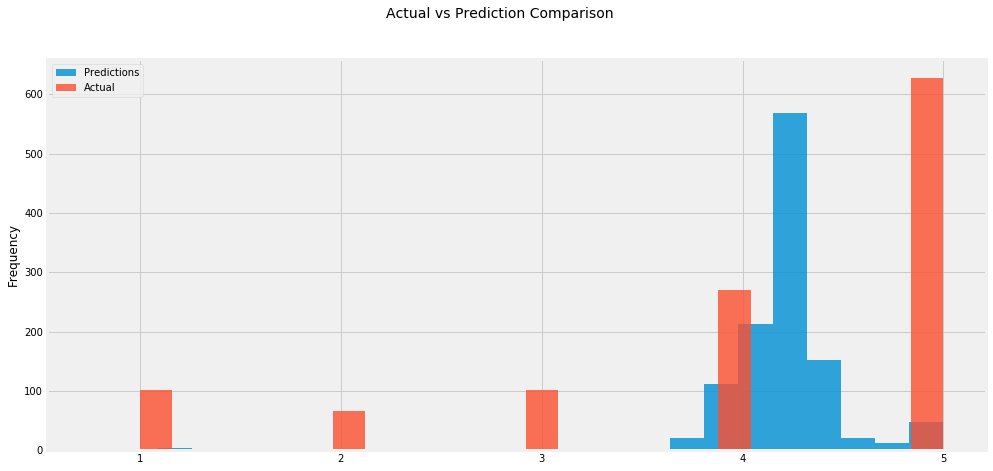

In [56]:
# Actual vs Prediction Comparison
print('Actual vs Prediction Comparison'); print('--'*30)

fig, ax = plt.subplots(figsize = (15, 7.2))
fig.suptitle('Actual vs Prediction Comparison', fontsize = 14)
df_user['EstRating'].plot.hist(bins = 25, alpha = 0.8)
df_user['ActualRating'].plot.hist(bins = 25, alpha = 0.8)
ax.legend(['Predictions', 'Actual'])
plt.show()

In [69]:
# Query top 5 recommendations for specific UserID
print('Get top - K ( K = 5) recommendations.')
print('Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.'); print('--'*40)
result = {}

def query_user(user_id):
  try:
    print('User "{}" has already rated products (from data in training set): {}'.format(user_id, train_data.loc[(train_data['UserID'] == user_id), 'ProductID'].nunique()))
    print('Top products from what\'s already being rated: {}'.format(list(train_data[(train_data['UserID'] == user_id)].sort_values(by = 'Rating', ascending = False).head(5)['ProductID'])))
  except:
    print('There\'s no data for the selected user in training set')
  print('Top  recommendations for the user are: {}'.format(list(df_user[(df_user['UserID'] == user_id)].sort_values(by = 'EstRating', ascending = False).head(5)['ProductID'])))
  return list(df_user[(df_user['UserID'] == user_id)].sort_values(by = 'EstRating', ascending = False).head(5)['ProductID'])

# For e.g. querying for the following user
print('A check on what has the user liked in past (based on data available in training set, if there is) and making recommendations');
print('--'*40, '\n')
result['A2IMLPUXYQJTSY'] = query_user('A2IMLPUXYQJTSY')
print('\n')
result['A14JBDSWKPKTZA'] = query_user('A14JBDSWKPKTZA')

Get top - K ( K = 5) recommendations.
Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.
--------------------------------------------------------------------------------
A check on what has the user liked in past (based on data available in training set, if there is) and making recommendations
-------------------------------------------------------------------------------- 

User "A2IMLPUXYQJTSY" has already rated products (from data in training set): 2
Top products from what's already being rated: ['B00000J434', 'B00000JFMK']
Top  recommendations for the user are: ['B00000J4FS', 'B00000JFMK']


User "A14JBDSWKPKTZA" has already rated products (from data in training set): 4
Top products from what's already being rated: ['B00000J1V5', 'B00000JDF5', 'B00000J1V1', 'B00000J3UH']
Top  recommendations for the user are: ['B00000J1V5', 'B00000JDF5', 'B00000J1V1', 'B00001ZWXA']


In [70]:
compare_dict['k-NN Item-based Collaborative Filtering'] = result
display(compare_dict)

{'SVD Item-based Collaborative Filtering': {'A10DIDVYDN2Q5Z': ['B00000JSGF',
   'B00001P4ZH',
   'B000023VUL',
   'B00000J061',
   'B00001W0DI'],
  'A11617B1NW474D': ['B00000JSGF',
   'B00001P4XH',
   'B000023VUL',
   'B00001W0DI',
   'B00000J061']},
 'k-NN Item-based Collaborative Filtering': {'A2IMLPUXYQJTSY': ['B00000J4FS',
   'B00000JFMK'],
  'A14JBDSWKPKTZA': ['B00000J1V5', 'B00000JDF5', 'B00000J1V1', 'B00001ZWXA']}}

In [71]:
df_user.head()

,UserID,ProductID,ActualRating,EstRating,Details,Error
744,A2R567Q24E6AW5,B00000J1V5,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00
504,AR52CXOX54AW6,B00001P505,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00
502,A2OKCS5234ZV7S,1400599997,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00
497,A2IMLPUXYQJTSY,B00000J4FS,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00
721,APV4CA1BTAGQ3,B00001P505,5.00,5.00,"{'actual_k': 1, 'was_impossible': False}",0.00


In [72]:
del (algo, ax, fig, gs_KNNBaseline, kf, param_grid_KNNBaseline, predictions, rmse, rmse_scores, train_, test_)

item based collaborative filtering using KNN Method and 2-Fold cross validation, we get a RMSE score of ~1.2247
.

# User Based Collaborative filtering Model using KNN 

In [73]:
print('USER BASED COLLABORATIVE FILTERING USING KNN Model')
print('Grid Search across parameter grid to find best parameters using KNNBaseline algorithm'); print('--'*30)
param_grid_KNNBaseline = {'bsl_options': {'method': ['als', 'sgd'], 'reg': [1, 2]}, 'k': [2, 3, 5], 
                          'sim_options': {'name': ['pearson_baseline', 'cosine'], 'user_based': [True]},
                          'verbose': [False]}

gs_KNNBaseline = GridSearchCV(KNNBaseline, param_grid_KNNBaseline, measures = ['rmse', 'mae'], cv = 5)
gs_KNNBaseline.fit(trainset)
print(gs_KNNBaseline.best_score['rmse'])
print(gs_KNNBaseline.best_params['rmse'])

USER BASED COLLABORATIVE FILTERING USING KNN Model
Grid Search across parameter grid to find best parameters using KNNBaseline algorithm
------------------------------------------------------------
1.2070148658722444
{'bsl_options': {'method': 'sgd', 'reg': 1}, 'k': 2, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}, 'verbose': False}


In [74]:
print('2-Fold cross validation using KNNBaseline and with best parameters identified during grid search'); print('--'*40)
kf = KFold(n_splits = 2)
algo = KNNBaseline(**gs_KNNBaseline.best_params['rmse'])
rmse_scores = []

for train_, test_ in kf.split(data):
    algo.fit(train_)
    predictions = algo.test(test_)
    rmse = round(accuracy.rmse(predictions, verbose = True), 4)
    rmse_scores.append(rmse)

    dump.dump('./dump_KNNBaseline_User', predictions, algo)

print('--'*40)
print(f'RMSE OF USER BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGORITHM AND 2-FOLD CROSS VALIDATION {round(np.mean(rmse_scores), 4)}')

2-Fold cross validation using KNNBaseline and with best parameters identified during grid search
--------------------------------------------------------------------------------
RMSE: 1.2077
RMSE: 1.1964
--------------------------------------------------------------------------------
RMSE OF USER BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGORITHM AND 2-FOLD CROSS VALIDATION 1.202


In [76]:
predictions, algo = dump.load('./dump_KNNBaseline_User')
df_user = pd.DataFrame(predictions, columns = ['UserID', 'ProductID', 'ActualRating', 'EstRating', 'Details'])
df_user['Error'] = abs(df_user['EstRating'] - df_user['ActualRating'])
df_user.sort_values('Error', inplace = True, ascending = True)

display(df_user.head(8))

,UserID,ProductID,ActualRating,EstRating,Details,Error
405,A1NZYQ9R9RJS7B,1400532655,4.00,4.00,"{'actual_k': 0, 'was_impossible': False}",0.00
18,A32KV93MO3CX9O,B00000JBHE,4.00,4.00,"{'actual_k': 0, 'was_impossible': False}",0.00
913,A1KY5G5FP31F2F,B0000226L0,4.00,4.00,"{'actual_k': 0, 'was_impossible': False}",0.00
620,A2ZC99NCD826JR,B00001P4YG,4.00,4.00,"{'actual_k': 0, 'was_impossible': False}",0.00
317,A3CMO216CWOF5N,B0000228GF,4.00,4.00,"{'actual_k': 0, 'was_impossible': False}",0.00
939,A1YCDZ4K4G0CN3,B00000JSGF,4.00,3.99,"{'actual_k': 0, 'was_impossible': False}",0.01
1048,A1VU2TOCKEOSQS,B00001P4PM,4.00,3.99,"{'actual_k': 0, 'was_impossible': False}",0.01
606,A5A4374R8I7NB,9043413585,4.00,4.01,{'was_impossible': False},0.01


In [80]:
print('Check on what has the user liked in past (based on data available in training set, if there is) and making recommendations');
print('--'*30, '\n')
result = {}

result['A11D1KHM7DVOQK'] = query_user('A11D1KHM7DVOQK')
print('\n')
result['A149RNR5RH19YY'] = query_user('A149RNR5RH19YY')

Check on what has the user liked in past (based on data available in training set, if there is) and making recommendations
------------------------------------------------------------ 

User "A11D1KHM7DVOQK" has already rated products (from data in training set): 4
Top products from what's already being rated: ['B00000JCTD', 'B00001ZWRV', 'B000001OMN', 'B00000JBYW']
Top  recommendations for the user are: ['B00001W0D4', 'B00000J9Z7', 'B00000JBYW']


User "A149RNR5RH19YY" has already rated products (from data in training set): 2
Top products from what's already being rated: ['B00000JBAM', 'B00001OPJ1']
Top  recommendations for the user are: ['B00001OPJ1']


In [81]:
compare_dict['KNN User-based Collaborative Filtering'] = result
display(compare_dict)

{'SVD Item-based Collaborative Filtering': {'A10DIDVYDN2Q5Z': ['B00000JSGF',
   'B00001P4ZH',
   'B000023VUL',
   'B00000J061',
   'B00001W0DI'],
  'A11617B1NW474D': ['B00000JSGF',
   'B00001P4XH',
   'B000023VUL',
   'B00001W0DI',
   'B00000J061']},
 'k-NN Item-based Collaborative Filtering': {'A2IMLPUXYQJTSY': ['B00000J4FS',
   'B00000JFMK'],
  'A14JBDSWKPKTZA': ['B00000J1V5', 'B00000JDF5', 'B00000J1V1', 'B00001ZWXA']},
 'KNN User-based Collaborative Filtering': {'A11D1KHM7DVOQK': ['B00001W0D4',
   'B00000J9Z7',
   'B00000JBYW'],
  'A149RNR5RH19YY': ['B00001OPJ1']}}

User based collaborative filtering using KNN method and 2-Fold cross validation, we get a RMSE score of ~1.202


# 8. Summarise your insights.

Conclusion

Non-personalized based recommendation system (such as popularity) is generated by averaging the recommendations for all the users. Here we recommended top 5 products to the users. Also saw how we can make use of count to suggest popular products to the users and hybrid popularity based recommender based on a combination of mean and count. However in popularity based recommendation, all users receive same recommendations. RMSE of popularity recommendation method based on mean of ratings was 
 2.7215.


Collaborative-based recommendations are personalized since the rating "prediction" differs depending on the target user and it is based on


Collaborative based filtering method requires a minimal knowledge engineering efforts when compared to methods such as content-based recsys. This method is based on user history, but what if the user is new (where there is no user history)? It's one of the limitations of the method known as cold-start problem.


Items with lots of history gets recommended a lot, while those without never make it into the recommendation engine.


Additionally, collaborative based filtering methods face scalability issues particularly in our case where the number of users are sparse, especially when recommendations need to be generated in real-time online. 


Since our objective was to build Recommendation system to recommend products to customers based on their previous ratings for other products, we built an item-based collaborative filtering recommendation system.
Used two model-based approaches : SVD and KNN 

 1)Item Based Collaborative Filtering using MATRIX FACTORIZATION METHOD (SVD)
    Evaluated SVD for item-based collaborative filtering and RMSE of SVD model 0.0103.

2 ) RMSE OF ITEM BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGORITHM AND 2-FOLD CROSS VALIDATION 1.2247 .

3) RMSE OF USER BASED COLLABORATIVE FILTERING USING k-NN INSPIRED ALGORITHM AND 2-FOLD CROSS VALIDATION 1.202


Item Based Collaborative Filtering using MATRIX FACTORIZATION METHOD is the best possible model for building Product Recommendations system. 